In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab Notebooks/sentiment analysis

/content/drive/MyDrive/Colab Notebooks/sentiment analysis


In [ ]:
import pandas as pd
import numpy as np

#LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# Pytorch Imports
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable

import time

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,classification_report,accuracy_score,confusion_matrix,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Embedding, BatchNormalization
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import text
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from nltk import word_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
nltk.download('punkt')

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('merged.csv')
# modify the ID 1 by 1; exp: imdb, yelp, amz
df = df[df['ID']=='Imdb']

In [ ]:
lbl_enc = preprocessing.LabelEncoder()
# encode the label to numbers
y = lbl_enc.fit_transform(df.New_Label.values)

In [ ]:
# train test split
xtrain, xvalid, ytrain, yvalid = train_test_split(df.Text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [ ]:
xtrain.shape

(800,)

In [ ]:
# create embedding matrix from glove vectors
embeddings_index = {}
f = open('../text/glove.840B.300d.txt')
for line in tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [02:00, 18162.12it/s]

Found 2196016 word vectors.


In [ ]:
# convert sentence to vector
def sent2vec(s):
    #  NLP preprocessing
    words = str(s).lower() # lowercase
    words = word_tokenize(words) # tokenize word
    words = [w for w in words if not w in stop_words] # remove stopwords
    words = [w for w in words if w.isalpha()] # only letters and numericals
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())


In [ ]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 200/200 [00:00<00:00, 4881.89it/s]


In [ ]:
# convert to numpy array
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [ ]:
xtrain_glove.shape

(800, 300)

In [ ]:
# scale the values to normal distribution
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [ ]:
# convert the label to binary class matrix
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences to same length 
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
# create an embedding matrix for the words in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector =  embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 3130/3130 [00:00<00:00, 338363.66it/s]


In [ ]:
xtrain_pad.shape

(800, 70)

In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
# embedding layer using glove vector
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
# lstm 1
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

# fully connected 1
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

# fully connected 2
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))

# output layer
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


In [ ]:
history = model.fit(xtrain_pad, y=ytrain_enc, batch_size=64, epochs=20, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Epoch 1/20
13/13 [==============================] - 11s 634ms/step - loss: 0.7369 - accuracy: 0.4975 - val_loss: 0.6832 - val_accuracy: 0.5450
Epoch 2/20
13/13 [==============================] - 4s 276ms/step - loss: 0.7037 - accuracy: 0.5100 - val_loss: 0.6711 - val_accuracy: 0.6600
Epoch 3/20
13/13 [==============================] - 4s 288ms/step - loss: 0.6911 - accuracy: 0.5550 - val_loss: 0.6583 - val_accuracy: 0.7100
Epoch 4/20
13/13 [==============================] - 5s 357ms/step - loss: 0.6657 - accuracy: 0.6000 - val_loss: 0.6302 - val_accuracy: 0.7250
Epoch 5/20
13/13 [==============================] - 3s 259ms/step - loss: 0.6303 - accuracy: 0.6325 - val_loss: 0.5817 - val_accuracy: 0.7450
Epoch 6/20
13/13 [==============================] - 4s 270ms/step - loss: 0.5875 - accuracy: 0.6900 - val_loss: 0.5196 - val_accuracy: 0.7550
Epoch 7/20
13/13 [==============================] - 3s 266ms/step - loss: 0.5503 - accuracy: 0.7400 - val_loss: 0.5467 - val_accuracy: 0.7100
Epoch

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

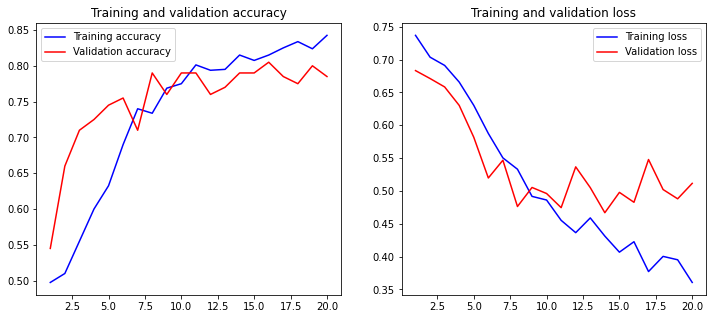

In [ ]:
plot_history(history)

In [ ]:
lstm_plt = {}
lstm_plt['train_loss'] = history.history['loss']
lstm_plt['train_acc'] = history.history['accuracy']
lstm_plt['test_loss'] = history.history['val_loss']
lstm_plt['test_acc'] = history.history['val_accuracy']
lstm_plt_df = pd.DataFrame.from_dict(lstm_plt,orient='index').T
lstm_plt_df.to_csv('LSTM_new_imdb_result.csv')